## Projeto em construção...

# 1. Importação das Bibliotecas

In [307]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# 2. Preparação dos Dados

In [308]:
# load the data
data = pd.read_csv('./CoversBR_metadata.csv', delimiter=';')
data.head()

,work_id,Music_Name,track_id,Artist_Name,Source,Genre_ECAD,Recording_Version,Duration,Fs,MBID,ISWC,ISRC,Country,Year
0,1,ADMIRAVEL GADO NOVO,19629,CASSIA ELLER,CD,ND,STUDIO,00:04:35.07,11025,8311499a-4e40-4afc-a826-6725d8454851,T0391535844,BRPGD9600090,BR,96
1,1,ADMIRAVEL GADO NOVO,23880,ZE RAMALHO,CD,ND,STUDIO,00:05:06.69,11025,1ec54f25-7525-480a-b7fa-4c79fc2ee05f,T0391535844,BRBMG9700282,BR,97
2,1,ADMIRAVEL GADO NOVO,579191,BIQUINI CAVADAO,IMPORTACAO,ND,STUDIO,00:04:21.77,11025,880622cf-96fd-4211-850f-9f914a5244c6,T0391535844,BRSME9400075,BR,94
3,1,ADMIRAVEL GADO NOVO,705173,OSWALDO MONTENEGRO,CD,ND,STUDIO,00:04:57.23,11025,23d08080-8113-47ea-b712-65acf448252f,T0391535844,BRABZ0300234,BR,03
4,1,ADMIRAVEL GADO NOVO,2164817,CASSIA ELLER,ND,ND,STUDIO,00:02:51.96,11025,ND,T0391535844,BRMCA9000102,BR,90


# 3. Análise Exploratória de Dados (AED)

In [309]:
# 1. #rows vs. #columns
data.shape

(102298, 14)

**Temos um dataset com 102.298 ocorrências (exemplos) e 14 características/features (colunas), sendo uma delas, o rótulo/label (saída esperada).**

In [310]:
# 2. data types
data.dtypes

work_id               int64
Music_Name           object
track_id              int64
Artist_Name          object
Source               object
Genre_ECAD           object
Recording_Version    object
Duration             object
Fs                    int64
MBID                 object
ISWC                 object
ISRC                 object
Country              object
Year                 object
dtype: object

**Artist_Name é o nosso label; Duration e Year, que foram obtidos como object, serão convertidos para o tipo de dado correspondente ao tempo de música e ao ano, respectivamente.**

In [311]:
# 3. convert 'Duration' and Year' to datetime and show a few rows
data['Duration'] = pd.to_datetime(data['Duration'], format='%H:%M:%S.%f', errors='coerce').dt.time # NaT for invalid Year values
data['Year'] = pd.to_datetime(data['Year'], format='%y', errors='coerce') # NaT for invalid Year values

data.sample(5)

,work_id,Music_Name,track_id,Artist_Name,Source,Genre_ECAD,Recording_Version,Duration,Fs,MBID,ISWC,ISRC,Country,Year
70874,6168504,AINDA LEMBRO,1586363,MARISA MONTE/ED MOTTA,CD,ND,STUDIO,00:03:58.010000,11025,ND,T0426515130,BRONE0500050,BR,2005-01-01
97723,18024617,ON GREEN DOLPHIN STREET,2565948,HERBIE HANCOCK,IMPORTACAO,ND,STUDIO,00:03:20.800000,11025,121d446c-6048-412c-b214-50a15e91308c,T0701588295,USSM10304304,US,2003-01-01
73507,6551142,TURN ME ON,5748491,DAVID GUETTA / NICKI MINAJ/NICKI MINAJ,IMPORTACAO,ND,REMIX,00:05:08.130000,11025,ND,ND,GB28K1100185,GB,2011-01-01
42200,1312393,DRAGOSTEA DIN TEI,3406513,O-ZONE,IMPORTACAO,ND,STUDIO,00:03:34.890000,11025,f24be8f2-53b4-4239-a861-e814faf2109d,T0044813435,NLD140900003,NL,2009-01-01
97740,18037530,COPIA MAL FEITA,13973958,BRUNO E BARRETTO,CAPTACAO RADIO,ND,STUDIO,00:03:11.170000,11025,ND,T0402707894,BXPNR1700013,BX,2017-01-01


**Existem exemplos com valores inválidos/missing values/em branco/não preenchidos/NaNs/NaTs, que poderão ser tratados nos próximos passos.**

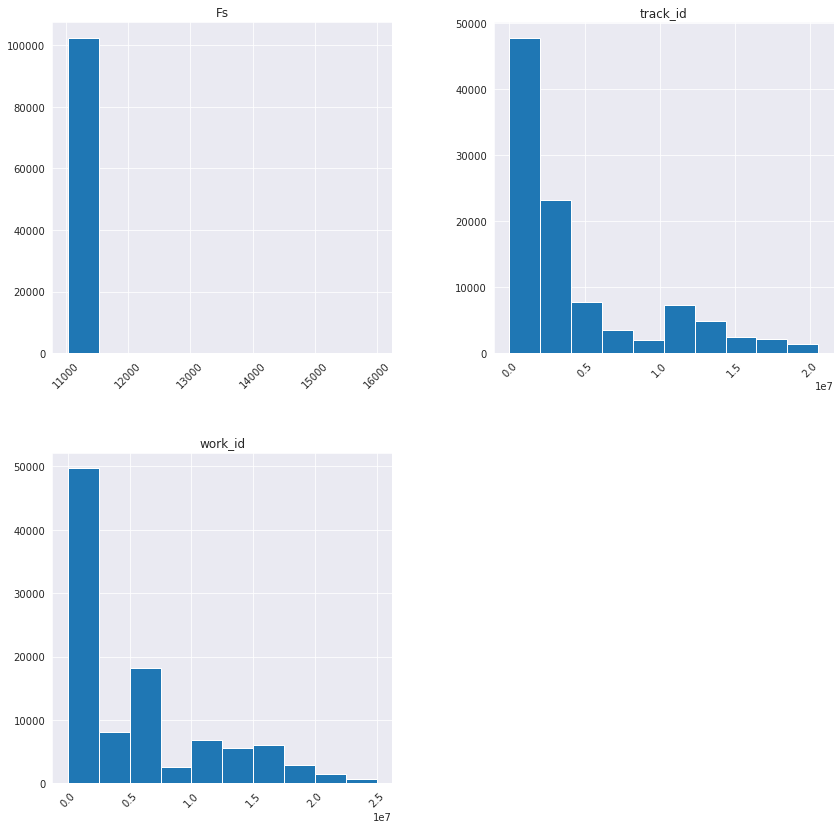

In [312]:
# 4. plot each numeric feature ----- *********userful to detect outliers*********
data.hist(figsize=(14,14), xrot=45)
plt.show()

**3 features são numéricas:**
1. Fs: frequência sonora da música (indo de ~11k até 16k);
2. track_id: número identificador da música;
3. work_id: número identificador do grupo de cover.

In [313]:
# 5. summary statistics of the numerical features
data.describe().T

,count,mean,std,min,25%,50%,75%,max
work_id,102298.0,5.165103e+06,6.015939e+06,1.0,40253.00,2835847.0,7788684.00,24998809.0
track_id,102298.0,4.452356e+06,4.886335e+06,15.0,1301414.25,2116795.0,6001035.75,20563324.0
Fs,102298.0,1.102763e+04,1.142731e+02,11025.0,11025.00,11025.0,11025.00,16000.0


**As medidas descritas sobre as features numéricas nos mostram:**

1. Fs: o espectro de ondas sonoras vai de 11.025,0 a 16.000,0, sendo pelo menos 75% decaindo sobre um Fs de 11.025; todos os exemplos aparentam estar preenchidos corretamente (102.298). 
2. track_id: todos os exemplos estão preenchidos nas 102.298 linhas (exemplos), começando em 15 e terminando em 20.563.324.
3. work_id: todos os exemplos estão preenchidos nas 102.298 linhas, começando em 1 e terminando em 24.998.809.

Sabe-se que a relação entre as músicas e os grupos de covers é a seguinte: existem 102.298 músicas, distribuídas em 26.366 grupos de covers. Isso implica que os ids dessas features não possuem uma relação unívoca, ou seja, a primeira track (música) não corresponde ao id 1, assim como o último work (grupo de cover) não corresponde ao id 26.366. Talvez, os ids tenham sido gerados de forma aleatória.

In [314]:
# 6. summary statistics of the categorical features
data.describe(include=['object', 'datetime']) # first and last values refers just to Year (datetime column)

,Music_Name,Artist_Name,Source,Genre_ECAD,Recording_Version,Duration,MBID,ISWC,ISRC,Country,Year
count,102298,102298,102298,102298,102298,102298,102298,102298,102298,102298,88849
unique,23776,23432,4,48,38,25752,30722,15889,88863,51,97
top,1. ALLEGRO,ELVIS PRESLEY,IMPORTACAO,ND,STUDIO,00:03:00,ND,ND,ND,BR,2003-01-01 00:00:00
freq,183,932,44623,98128,80369,306,51488,34976,13372,41063,4360
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1969-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2068-01-01 00:00:00


**As demais 11 features são categóricas (incluindo uma, Year, de data):**

1. Music_Name: possui diversos valores repetidos, mas todos os exemplos estão preenchidos. A música com cover mais comum possui 183 entradas e contém em seu nome o texto "1. ALLEGRO".
2. Artist_Name: existem aproximadamente 23 mil artistas diferentes. O cover mais comum é do cantor Elvis Presley, com 932 entradas.
3. Source: há somente 4 fontes de gravação dos covers, sendo a mais comum - importação.
4. Genre_ECAD: existem 48 gêneros musicais distintos (baseados no Escritório Central de Arrecadação e Distribuição - ECAD).
5. Recording_Version: existem 38 versões de gravação diferentes, sendo a de estúdio, a mais comum (80.369 entradas).
6. Duration: o tempo mais comum das músicas é o de 3 minutos de duração. Este tempo está relacionado com as conhecidas "versões de rádio".
7. MBID: da mesma forma que há músicas que se repetem, há diversos exemplos com o identificador MusicBrainz (MBID) repetido.
8. ISWC: este ID único aparece repetido (diversas vezes), porque há registros da mesma música (várias vezes) no dataset.
9. ISRC: este ID, que identifica unicamente uma gravação, pode aparecer repetido devido a mais de uma entrada do mesmo cover no dataset.
10. Country: há músicas de diversos países, sendo o Brasil o país com maior número de registros (41.063). Ainda não se pode afirmar se são 51 países distintos sem antes analisar os exemplos com mais cuidado.
11. Year: há registros incorretos que apontam para anos no futuro. Deve-se analisar melhor esses dados nos próximos passos.

**Como descrito nas informações oficiais do dataset, as seguintes features possuem todos os valores informados:**

- work_id
- track_id
- Music_Name
- Artist_Name
- Duration

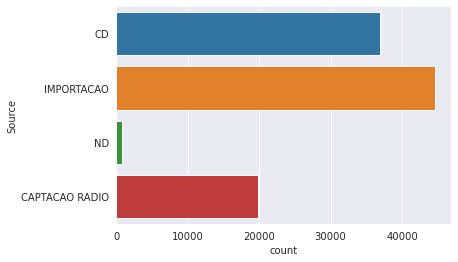

In [315]:
# 7. explore Source feature
sns.countplot(y='Source', data=data)
plt.show()

**A primeira feature a ser analisada em mais detalhes é a *Source*, que contém 4 classes distintas:**

Percebe-se que existem entradas **ND**, que são aquelas que não estão dentre CD, importação e captação de rádio.

In [316]:
# 8. explore Genre_ECAD feature
data['Genre_ECAD'].unique()

array(['ND', 'PAGODE', 'SAMBA CANCAO', 'MPB', 'SAMBA', 'SERTANEJO',
       'BOSSA NOVA', 'FORRO', 'TANGO', 'POP MUSIC', 'VANEIRAO',
       'ROMANTICO', 'ROCK', 'SAMBA ENREDO', 'HINO', 'TIMBALADA', 'FREVO',
       'MAXIXE', 'TOADA', 'EVANGELICA', 'DANCE MUSIC', 'BAIAO', 'CHORO',
       'VALSA', 'FUNK', 'FOX-TROT', 'CLASSICA', 'BOLERO', 'HEAVY METAL',
       'MARCHA-RANCHO', 'XOTE', 'AXE MUSIC', 'GOSPEL', 'RELIGIOSO', 'RAP',
       'MARCHA', 'INSTRUMENTAL', 'REGGAE', 'BALADA', 'LAMBADA', 'CANCAO',
       'CATOLICO', 'CALYPSO', 'WORLD MUSIC', 'REGIONAL', 'SOUL', 'SACRA',
       'OUTROS'], dtype=object)

**A segunda feature a ser explorada é *Genre_ECAD*, que contém 48 classes distintas:**

Percebe-se que existem entradas **ND**, que correspondem a gêneros desconhecidos ou não informados. Percebe-se que há covers, também, de músicas **instrumentais** e eletrônicas como **dance music**, que são gêneros que não apresentam necessariamente vocal, mas tão somente instrumentos musicais/eletrônicos.

In [317]:
# 9. explore Recording_Version feature
data['Recording_Version'].unique()

array(['STUDIO', 'LIVE (AO VIVO)', 'REMIX', 'TAPE', 'ACUSTICO',
       'ACUSTICO MTV', 'UNPLUGGED (ACUSTICO)', 'ND', 'ACUSTICO AO VIVO',
       'RADIO REMIX', 'HOUSE EDIT', 'DVD', 'A CAPELA', 'RADIO VERSION',
       'STUDIO VERSION', 'NI', 'MTV AO VIVO', 'MIX', 'ALBUM', 'VHS',
       'VINHETA', 'MEME SUPER CLUB MIX 2002', 'POP MIX', 'EXTENDED MIX',
       'BIBLIOTECA', 'RADIO EDIT', 'ROCK VERSION', 'G-VO MIX', 'SURTO',
       'CLUB REMIX', 'PLAY BACK', 'RADIO MIX', 'LONG VERSION',
       'EDITED SLOW', 'EDIT MIX', 'XRS REMIX RADIO EDIT', 'LOUNGE MIX',
       'GROOVE MIX'], dtype=object)

**A terceira feature a ser explorada é *Recording_Version*, que contém 38 classes distintas:**

Nota-se entradas **ND**, também, para esta feature. Conforme informações oficiais dos autores do dataset, as classes mais comuns dentre os covers gravados são: estúdio, live (ao vivo) e remix. No próximo posso confirmamos por meio de um gráfico.

   Recording_Version  Ocorrências
30            STUDIO        80369
14    LIVE (AO VIVO)        17504
28             REMIX         2765
20                ND          671
1           ACUSTICO          205
---


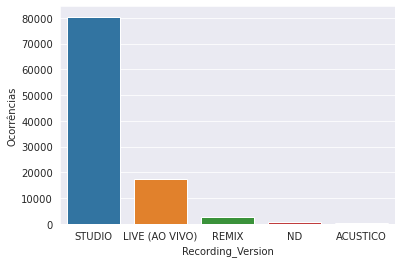

In [318]:
# 9.continuation. plot most frequent classes
recording_version = data[['Artist_Name', 'Recording_Version']].copy()
recording_version = recording_version.groupby(by=['Recording_Version']).count().reset_index()
recording_version_TOP = recording_version.sort_values('Artist_Name', ascending=False)
recording_version_TOP.rename(index=str, columns={'Artist_Name': 'Ocorrências'}, inplace=True)
recording_version_TOP_5 = recording_version_TOP.head(5)

print(recording_version_TOP_5)
print('---')

# plot results
recording_version_TOP_5_plot = sns.barplot(x='Recording_Version', y='Ocorrências', data=recording_version_TOP_5)

In [319]:
# 10. explore Duration feature
isNegativeHour = data['Duration'] < dt.time(hour=0) # are there negative hours?
isNegativeMinute = data['Duration'] <= dt.time(minute=0) # are there negative, or zero, minutes?

print(isNegativeHour.value_counts())
print('---')
print(isNegativeMinute.value_counts())

False    102298
Name: Duration, dtype: int64
---
False    102298
Name: Duration, dtype: int64


**Ao explorar a quarta feature, *Duration*, que contém 25.752 classes distintas, temos que:**

Todas as classes contém valores de duração de música válidos. (Os valores tratados como inválidos são considerados como NaT.) Temos 102.298 exemplos (mesmo número de linhas do dataset) com valores iguais a NaT ou iguais a um tempo válido de hora:minuto:segundo.microsegundo.

In [320]:
# 11. explore Country feature

#doing...

# 999. Referências

1. Dirceu Silva, Atila Xavier, Edgard Moraes, Marco Grivet and Fernando Perdigão. CoversBR: A Large Dataset for Cover Song Identification. https://github.com/SPLab-IT/CoversBR